In [44]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import h5py
import time
from skimage import transform
from scipy.io import loadmat
from behavenet import get_user_dir

This notebook provides a more in-depth example for how to put video and neural data into the BehaveNet hdf5 format.

<br>

The video data and neural data must contain the same number of frames per trial. In this case, when using an mp4 file, we assume that the neural activity has been binned or interpolated to match the frame rate of the behavioral video.

<br>

We'll use opencv to load the video data one trial at a time. You must first install opencv in the "behavenet" environment using pip:
```
(behavenet) $: pip install opencv-python
```

<br>

The following files are required:
* mp4 file: mp4 of behavorial video (can be any format readable by open cv)
* mp4 indices: saved in `neural_dir/batch_video_id.mat`; this file contains a single matrix named 'batch_video_id' with shape (2, n_trials). The first row contains the start index of each trial (with respect to the total number of frames in the mp4 file), and the second row contains the final index of each trial
* neural data: saved in `neural_dir/neural_activity`; this file contains a single matrix named 'neural_activity' with shape (n_time, n_neurons)
* neural indices: saved in `neural_dir/batch_neural_id.mat`; this file contains a single matrix named 'batch_neural_id' with shape (2, n_trials). The first row contains the start index of each trial (with respect to the 'neural_activity' matrix), and the second row contains the final index of each trial.

# load data

In [60]:
vid_id = '2018-04-04_3_MD0ST5'
neural_dir ='neural_dir/'


In [61]:
vvi = loadmat(os.path.join(neural_dir, 'batch_video_id' + vid_id + '.mat'))['batch_video_id']
nni = loadmat(os.path.join(neural_dir, 'batch_neural_id' + vid_id + '.mat'))['batch_neural_id']
nna = loadmat(os.path.join(neural_dir, 'neural_activity' + vid_id + '.mat'))['neural_activity']


### set paths

In [62]:
# data will be stored in data_dir/lab/expt/animal/session/data.hdf5
lab = 'dipoppa' # choose a name
expt = 'full_trial' # choose a name
animal = 'MD0ST5'# choose a name
session = '3' # choose a name

mp4_file = neural_dir + vid_id + '_eye.mj2'# /path/to/mp4_file.mp4 (can be any format loadable by open cv)

# video frames will be resized to these dimensions
# downsampling is preferrable as it speeds up autoencoder fitting time
# we typically use images with the largest dimension <= 256
xpix = 256 # choose a number (e.g. 256)
ypix = 128 # choose a number (e.g. 128)

# processed data in behavenet format will be stored here
data_dir = get_user_dir('data')
proc_data_filepath = os.path.join(data_dir, lab, expt, animal, session)
print(proc_data_filepath)

/home/yoni/behavenet/data/dipoppa/full_trial/MD0ST5/3


### helper functions

In [63]:
def get_frames_from_idxs(cap, idxs):
    """Helper function to load video segments.

    Args:
        cap (cv2.VideoCapture object):
        idxs (array-like): frame indices into vido

    Returns:
        np.ndarray of shape (n_frames, y_pix, x_pix)
    """
    n_frames = len(idxs)
    for fr, i in enumerate(idxs):
        if fr == 0:
            cap.set(1 , i)
        ret, frame = cap.read()
        if ret:
            if fr == 0:
                height, width, _ = frame.shape
                frames = np.zeros((n_frames, 1, height, width), dtype='uint8')
            frames[fr, 0, :, :] = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
        else:
            print(
                'warning! reached end of video; returning blank frames for remainder of ' +
                'requested indices')
            break
    return frames

### loop over trials and load frames

In [64]:
# set up hdf5 file
hdf5_file = os.path.join(proc_data_filepath, 'data.hdf5')
if os.path.exists(hdf5_file):
    raise IOError('data.hdf5 file already exists; skipping')
else:
    hdf5_dir = os.path.dirname(hdf5_file)
    if not os.path.exists(hdf5_dir):
        os.makedirs(hdf5_dir)
        
# read video file and check
cap = cv2.VideoCapture(mp4_file)
if not cap.isOpened():
    raise IOError('error opening video file at %s' % mp4_file)

total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))

n_trials = vvi.shape[1]
n_trials

396

In [65]:
t_beg = time.time()
with h5py.File(hdf5_file, 'w', libver='latest', swmr=True) as f:
    
    # single write multi-read
    f.swmr_mode = True  

    # create image group
    group_i = f.create_group('images')
    
    # create image group
    group_n = f.create_group('neural')
    
    # create a dataset for each trial within groups
    t = 0
    for trial in range(n_trials):

        if trial % 5 == 0:
            print('processing trial %03i' % trial)

        # find video indices during this trial
        trial_beg = vvi[0, trial]
        trial_end = vvi[1, trial]
        ts_idxs = np.arange(trial_beg-1,trial_end)

        # load and process corresponding frames
        frames = get_frames_from_idxs(cap, ts_idxs)
        sh = frames.shape
        frames_proc = np.zeros((sh[0], sh[1], ypix, xpix), dtype='uint8')
        for i in range(sh[0]):
            frames_proc[i, 0, :, :] = cv2.resize(
                frames[i, 0], (xpix, ypix))

        # save image data
        group_i.create_dataset('trial_%04i' % t, data=frames_proc, dtype='uint8')

        # find neural indices during this trial
        trial_beg = nni[0, trial]
        trial_end = nni[1, trial]

        # pick out corresponding neural activity
        neural = nna[trial_beg-1:trial_end,:]

        print(neural.shape)
        # save neural data
        group_n.create_dataset('trial_%04i' % t, data=neural, dtype='float32')

        t += 1

# print out timing info
t_end = time.time()
t_tot = t_end - t_beg
print('total processing time: %f sec' % t_tot)
print('time per trial: %f sec' % (t_tot / n_trials))

processing trial 000
(150, 1452)
(150, 1452)
(150, 1452)
(150, 1452)
(150, 1452)
processing trial 005
(150, 1452)
(150, 1452)
(150, 1452)
(150, 1452)
(150, 1452)
processing trial 010
(150, 1452)
(150, 1452)
(150, 1452)
(150, 1452)
(150, 1452)
processing trial 015
(150, 1452)
(150, 1452)
(150, 1452)
(150, 1452)
(150, 1452)
processing trial 020
(150, 1452)
(150, 1452)
(150, 1452)
(150, 1452)
(150, 1452)
processing trial 025
(150, 1452)
(150, 1452)
(150, 1452)
(150, 1452)
(150, 1452)
processing trial 030
(150, 1452)
(150, 1452)
(150, 1452)
(150, 1452)
(150, 1452)
processing trial 035
(150, 1452)
(150, 1452)
(150, 1452)
(150, 1452)
(150, 1452)
processing trial 040
(150, 1452)
(150, 1452)
(150, 1452)
(150, 1452)
(150, 1452)
processing trial 045
(150, 1452)
(150, 1452)
(150, 1452)
(150, 1452)
(150, 1452)
processing trial 050
(150, 1452)
(150, 1452)
(150, 1452)
(150, 1452)
(150, 1452)
processing trial 055
(150, 1452)
(150, 1452)
(150, 1452)
(150, 1452)
(150, 1452)
processing trial 060
(150, 1

### test extraction

343
images: (150, 1, 128, 256)
neural: (150, 1452)


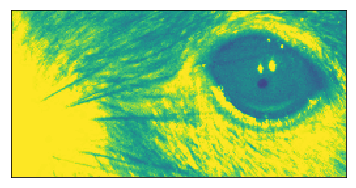

In [66]:
indx = np.random.randint(n_trials)
print(indx)
with h5py.File(hdf5_file, 'r', libver='latest', swmr=True) as file:
    images = file['images'][str('trial_%04i' % indx)][()]
    
    neural = file['neural'][str('trial_%04i' % indx)][()]

print(str('images: {}'.format(images.shape)))
print(str('neural: {}'.format(neural.shape)))

# plot image
plt.figure(figsize=(6, 6))
plt.imshow(images[0, 0], vmin=0, vmax=255)
plt.xticks([])
plt.yticks([])
plt.show()